In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import json
import re

# --- Configuration ---
ANALYSIS_FOLDER = 'statistical_analysis'
VISUALIZATION_FOLDER = 'visualizations'
JSON_FOLDER = 'data_json'
os.makedirs(VISUALIZATION_FOLDER, exist_ok=True)

summary_csv_path = os.path.join(ANALYSIS_FOLDER, 'statistical_summary.csv')

# --- Plotting Style ---
sns.set_theme(style="whitegrid", context="talk", font_scale=0.9)
# Define a professional and distinct color palette
palette = {
    'decoder_only': '#1f77b4',    # Muted Blue
    'encoder_only': '#2ca02c',    # Forest Green
    'encoder_decoder': '#ff7f0e' # Safety Orange
}

In [12]:
try:
    df_summary = pd.read_csv(summary_csv_path)
    # A helper column for combined architecture + size plotting
    df_summary['architecture'] = df_summary['arch_type'] + '_' + df_summary['size_variant']

    print("✅ Successfully loaded and prepared the statistical summary data.")
    display(df_summary.head())
except FileNotFoundError:
    print(f"❌ ERROR: File not found at '{summary_csv_path}'.")
    print("Please run the 'analysis.ipynb' notebook first.")

✅ Successfully loaded and prepared the statistical summary data.


,arch_type,size_variant,dataset_size,n_params,val_loss_mean,val_loss_std,val_accuracy_mean,val_accuracy_std,training_time_mean,training_time_std,architecture
0,decoder_only,base,1000,2343304,8.488891,0.012199,0.0,0.0,1.595834,0.148340,decoder_only_base
1,decoder_only,base,5000,2343304,7.782166,0.009035,0.0,0.0,7.497437,0.297877,decoder_only_base
2,decoder_only,base,10000,2343304,7.162202,0.030113,0.0,0.0,14.785040,0.135116,decoder_only_base
3,decoder_only,small,1000,778504,8.551616,0.008455,0.0,0.0,1.093013,0.444149,decoder_only_small
4,decoder_only,small,5000,778504,7.953337,0.006059,0.0,0.0,4.298236,0.424087,decoder_only_small


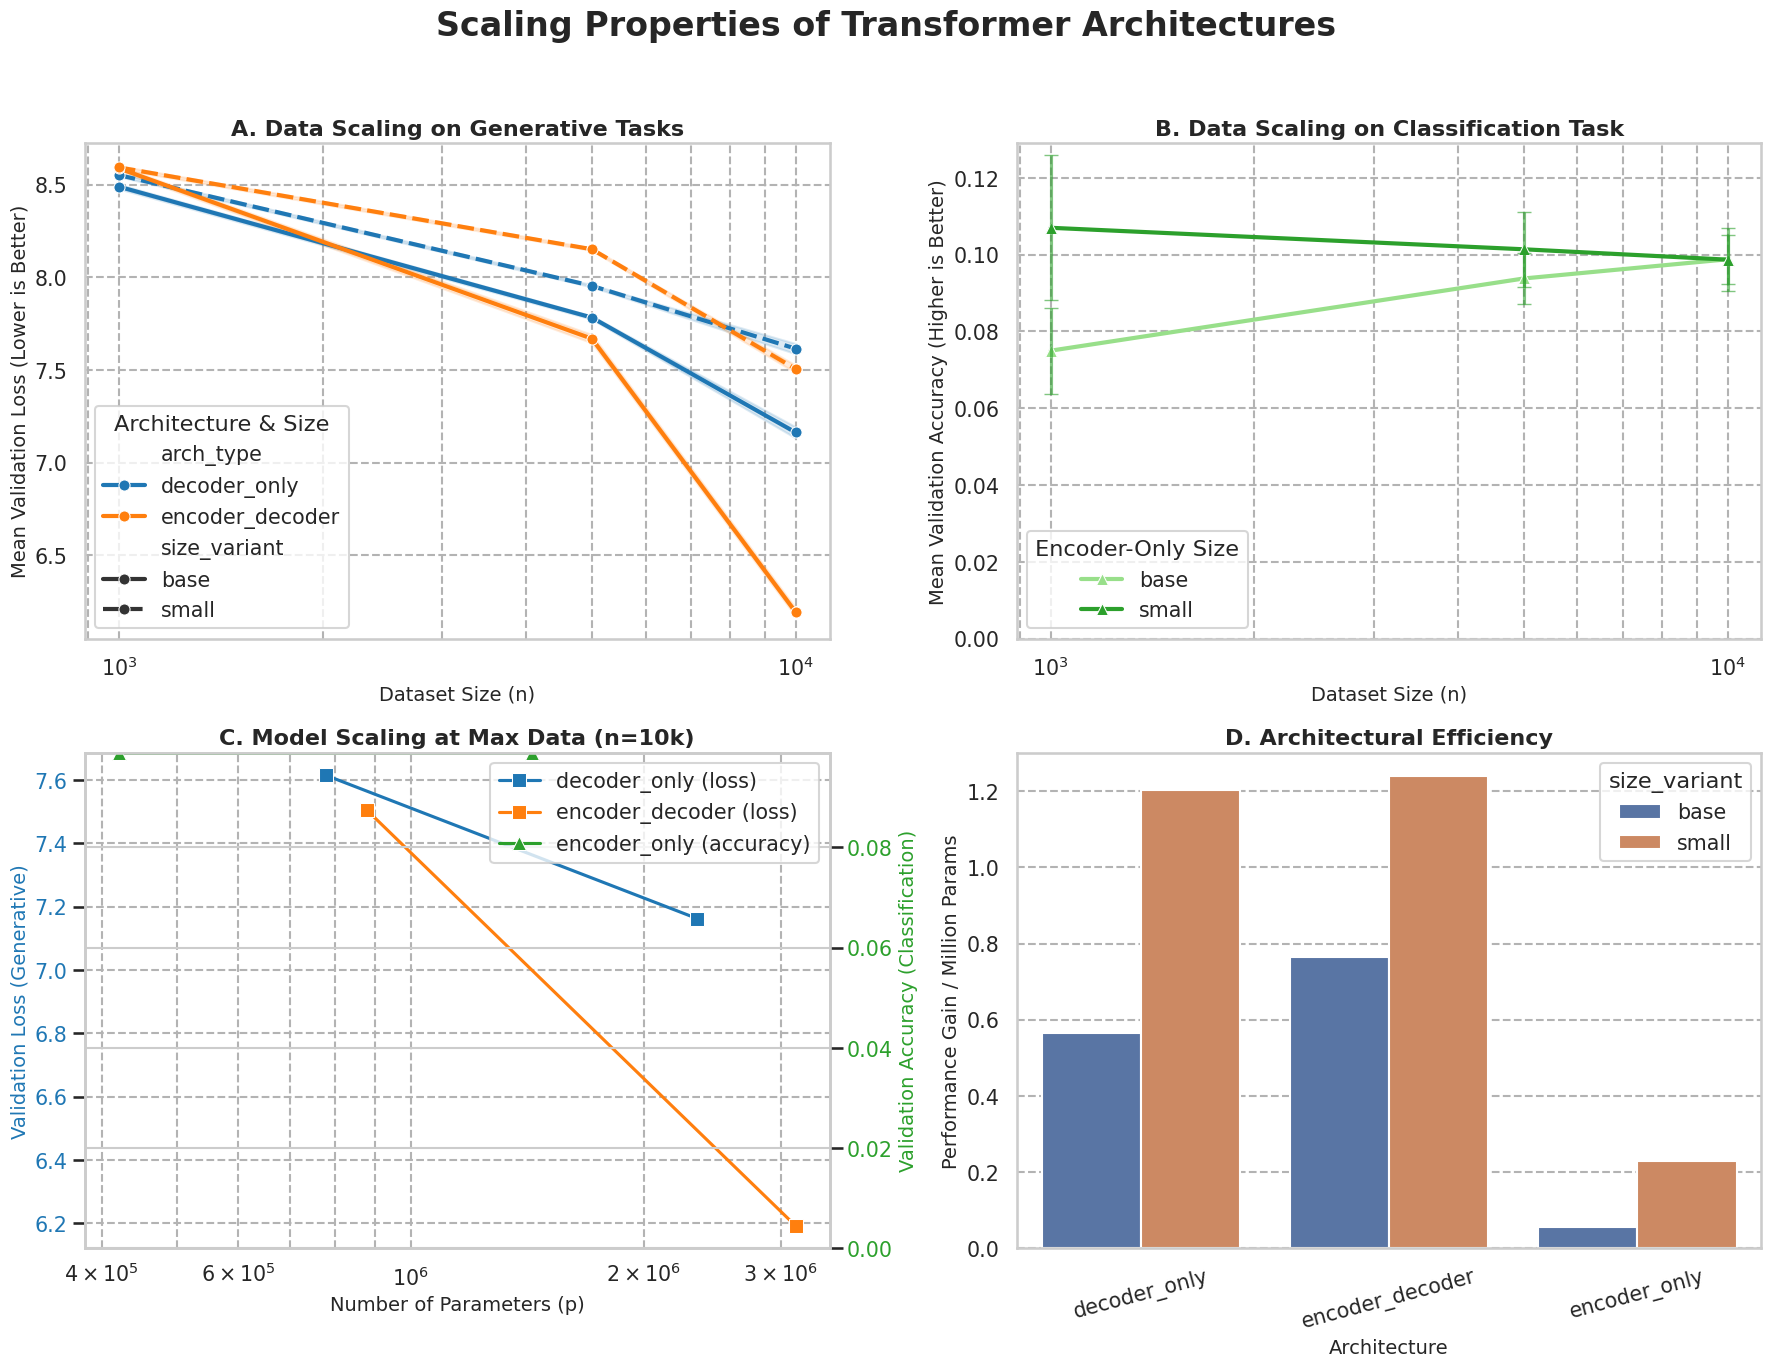

✅ Comprehensive plot saved to 'visualizations/fig_comprehensive_transformer_scaling.png'


In [7]:
if 'df_summary' in locals():
    # Create a 2x2 grid for our plots
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Scaling Properties of Transformer Architectures', fontsize=24, weight='bold')

    # --- Plot A: Data Scaling for Generative Models (Loss) ---
    ax = axes[0, 0]
    df_gen = df_summary[df_summary['arch_type'].isin(['decoder_only', 'encoder_decoder'])]

    sns.lineplot(
        data=df_gen, x='dataset_size', y='val_loss_mean',
        hue='arch_type', style='size_variant',
        ax=ax, palette=palette, marker='o', linewidth=3, markersize=8
    )
    # Add shaded error bands for standard deviation
    for name, group in df_gen.groupby(['arch_type', 'size_variant']):
        ax.fill_between(
            group['dataset_size'],
            group['val_loss_mean'] - group['val_loss_std'],
            group['val_loss_mean'] + group['val_loss_std'],
            color=palette[name[0]],
            alpha=0.15
        )
    ax.set_title('A. Data Scaling on Generative Tasks', weight='bold', fontsize=16)
    ax.set_xlabel('Dataset Size (n)', fontsize=14)
    ax.set_ylabel('Mean Validation Loss (Lower is Better)', fontsize=14)
    ax.set_xscale('log')
    ax.legend(title='Architecture & Size')
    ax.grid(True, which="both", ls="--", c='0.7')

    # --- Plot B: Data Scaling for Classification Model (Accuracy) ---
    ax = axes[0, 1]
    df_class = df_summary[df_summary['arch_type'] == 'encoder_only']

    sns.lineplot(
        data=df_class, x='dataset_size', y='val_accuracy_mean',
        hue='size_variant',
        ax=ax, palette={'small': '#2ca02c', 'base': '#98df8a'}, marker='^', linewidth=3, markersize=8
    )
    # Add error bars for accuracy
    for name, group in df_class.groupby('size_variant'):
        ax.errorbar(group['dataset_size'], group['val_accuracy_mean'], yerr=group['val_accuracy_std'], fmt='none', color=palette['encoder_only'], capsize=5, alpha=0.6)

    ax.set_title('B. Data Scaling on Classification Task', weight='bold', fontsize=16)
    ax.set_xlabel('Dataset Size (n)', fontsize=14)
    ax.set_ylabel('Mean Validation Accuracy (Higher is Better)', fontsize=14)
    ax.set_xscale('log')
    ax.set_ylim(bottom=0)
    ax.legend(title='Encoder-Only Size')
    ax.grid(True, which="both", ls="--", c='0.7')

    # --- Plot C: Model Scaling (Performance vs. Parameters) ---
    ax = axes[1, 0]
    df_largest_n = df_summary[df_summary['dataset_size'] == df_summary['dataset_size'].max()]

    for arch_type, group in df_largest_n.groupby('arch_type'):
        if arch_type != 'encoder_only':
            sns.lineplot(data=group, x='n_params', y='val_loss_mean', color=palette[arch_type],
                         marker='s', markersize=10, ax=ax, label=f'{arch_type} (loss)')
    ax.set_xlabel('Number of Parameters (p)', fontsize=14)
    ax.set_ylabel('Validation Loss (Generative)', color='#1f77b4', fontsize=14)
    ax.tick_params(axis='y', labelcolor='#1f77b4')
    ax.set_xscale('log')
    ax.grid(True, which="both", ls="--", c='0.7')

    ax2 = ax.twinx()
    encoder_group = df_largest_n[df_largest_n['arch_type'] == 'encoder_only']
    sns.lineplot(data=encoder_group, x='n_params', y='val_accuracy_mean', color=palette['encoder_only'],
                 marker='^', markersize=10, ax=ax2, label='encoder_only (accuracy)')
    ax2.set_ylabel('Validation Accuracy (Classification)', color=palette['encoder_only'], fontsize=14)
    ax2.tick_params(axis='y', labelcolor=palette['encoder_only'])
    ax2.set_ylim(bottom=0)

    ax.set_title('C. Model Scaling at Max Data (n=10k)', weight='bold', fontsize=16)
    # Manually combine legends
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')
    ax.get_legend().remove()

    # --- Plot D: Architectural Efficiency Summary ---
    ax = axes[1, 1]
    # Calculate performance improvement (delta) from smallest to largest dataset
    df_perf_gain = df_summary.pivot_table(
        index=['arch_type', 'size_variant', 'n_params'],
        columns='dataset_size',
        values=['val_loss_mean', 'val_accuracy_mean']
    ).reset_index()

    # Flatten multi-index columns
    df_perf_gain.columns = ['_'.join(map(str, col)).strip('_') for col in df_perf_gain.columns.values]

    min_n, max_n = df_summary['dataset_size'].min(), df_summary['dataset_size'].max()

    # Calculate gain (lower loss is better, so we negate the change)
    df_perf_gain['loss_gain'] = -(df_perf_gain[f'val_loss_mean_{max_n}'] - df_perf_gain[f'val_loss_mean_{min_n}'])
    df_perf_gain['accuracy_gain'] = df_perf_gain[f'val_accuracy_mean_{max_n}'] - df_perf_gain[f'val_accuracy_mean_{min_n}']

    # Combine gains into a single column for plotting
    df_perf_gain['performance_gain'] = df_perf_gain['loss_gain'].fillna(df_perf_gain['accuracy_gain'])

    # Calculate efficiency per million parameters
    df_perf_gain['efficiency'] = df_perf_gain['performance_gain'] / (df_perf_gain['n_params'] / 1_000_000)

    sns.barplot(data=df_perf_gain, x='arch_type', y='efficiency', hue='size_variant', ax=ax)
    ax.set_title('D. Architectural Efficiency', weight='bold', fontsize=16)
    ax.set_xlabel('Architecture', fontsize=14)
    ax.set_ylabel('Performance Gain / Million Params', fontsize=14)
    ax.tick_params(axis='x', rotation=15)
    ax.grid(True, axis='y', ls="--", c='0.7')

    # --- Final Touches ---
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    output_path = os.path.join(VISUALIZATION_FOLDER, 'fig_comprehensive_transformer_scaling.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Comprehensive plot saved to '{output_path}'")


--- Generating P/N Ratio vs. Generalization Gap Plot ---


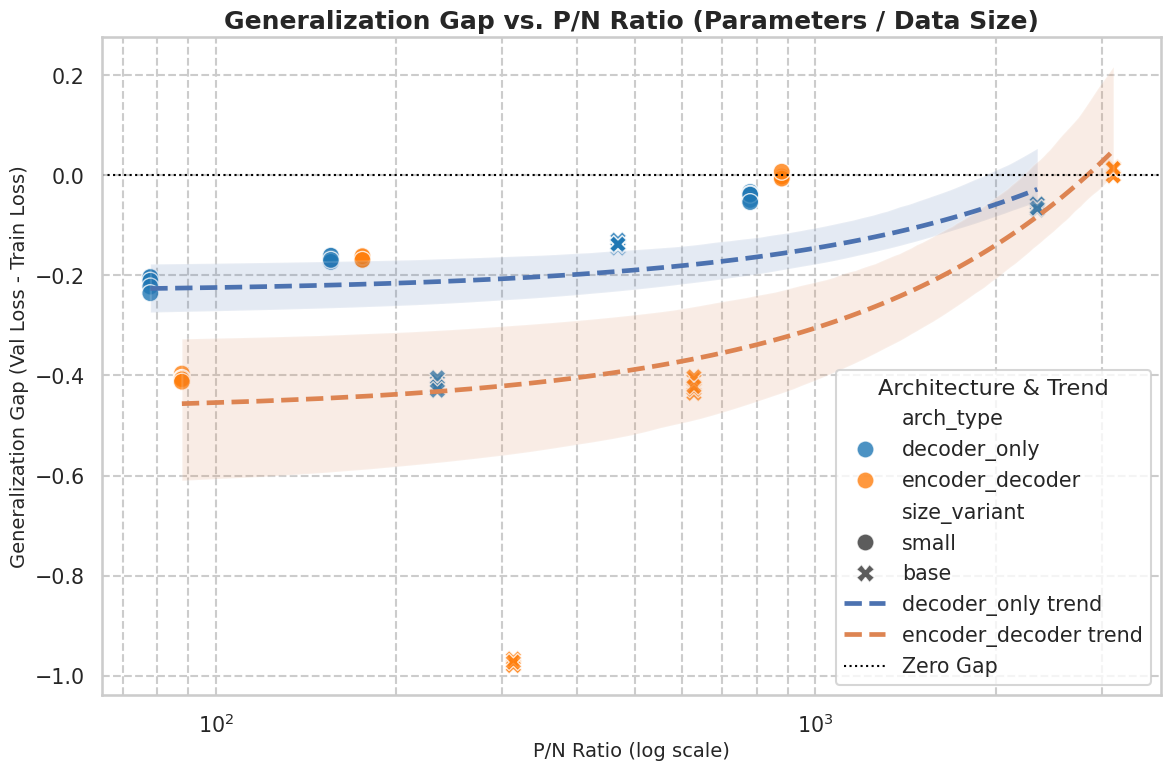

✅ P/N Ratio plot saved to 'visualizations/fig_pn_ratio_vs_gen_gap.png'


In [16]:
if 'df_summary' in locals():
    print("\n--- Generating P/N Ratio vs. Generalization Gap Plot ---")

    # Step 1: Reparse the raw JSON data to get training loss
    # This is necessary because the previous summary didn't include it.
    json_files = sorted(glob(os.path.join(JSON_FOLDER, 'transformer_architecture_scaling_results-*.json')))
    if not json_files:
        print("❌ Raw JSON files not found. Cannot generate this plot.")
    else:
        raw_data = []
        for i, file_path in enumerate(json_files):
            with open(file_path, 'r') as f:
                data = json.load(f)
            for key, metrics in data.items():
                # Extract final train loss from the history
                train_loss = metrics.get('full_history', {}).get('train_loss', [None])[-1]
                if train_loss is not None:
                    record = {
                        'run_id': i + 1,
                        'arch_type': metrics.get('config', {}).get('arch_type'),
                        'size_variant': metrics.get('config', {}).get('name').split('_')[-1],
                        'n_params': metrics.get('n_params'),
                        'dataset_size': metrics.get('dataset_size'),
                        'val_loss': metrics.get('final_val_loss'),
                        'train_loss': train_loss
                    }
                    raw_data.append(record)

        df_raw = pd.DataFrame(raw_data)

        # Step 2: Calculate P/N Ratio and Generalization Gap
        df_raw['p_n_ratio'] = df_raw['n_params'] / df_raw['dataset_size']
        df_raw['gen_gap'] = df_raw['val_loss'] - df_raw['train_loss']

        # Step 3: Create the plot
        plt.figure(figsize=(12, 8))

        # We only plot this for generative models, as gen_gap for classification is not directly comparable
        df_plot = df_raw[df_raw['arch_type'].isin(['decoder_only', 'encoder_decoder'])]

        plot = sns.scatterplot(
            data=df_plot,
            x='p_n_ratio',
            y='gen_gap',
            hue='arch_type',
            style='size_variant',
            s=150,  # size of markers
            alpha=0.8,
            palette=palette
        )

        # Add a regression line to show the trend for each architecture
        for arch_type, group in df_plot.groupby('arch_type'):
            sns.regplot(data=group, x='p_n_ratio', y='gen_gap', scatter=False, ax=plot,
                        line_kws={'linestyle':'--'}, label=f'{arch_type} trend')

        plot.set_title('Generalization Gap vs. P/N Ratio (Parameters / Data Size)', fontsize=18, weight='bold')
        plot.set_xlabel('P/N Ratio (log scale)', fontsize=14)
        plot.set_ylabel('Generalization Gap (Val Loss - Train Loss)', fontsize=14)
        plot.set_xscale('log')
        plot.axhline(0, color='black', linestyle=':', linewidth=1.5, label='Zero Gap')

        # Clean up the legend
        handles, labels = plot.get_legend_handles_labels()
        # This is a bit of a hack to combine scatter and line legends correctly
        unique_labels = dict(zip(labels, handles))
        plot.legend(unique_labels.values(), unique_labels.keys(), title='Architecture & Trend')

        plot.grid(True, which="both", ls="--", c='0.8')
        plt.tight_layout()

        output_path = os.path.join(VISUALIZATION_FOLDER, 'fig_pn_ratio_vs_gen_gap.png')
        plt.savefig(output_path, dpi=300)
        plt.show()
        print(f"✅ P/N Ratio plot saved to '{output_path}'")
